# Crop AVISO dataset to LBE

Data file from AVISO: 'META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc'

Also tested the twosat dataset, but it had more breaks in the LBE, so chose to move forward using allsat. There were no short tracks (<10 day) in the LBE location, only long (10+). 

Lexi Jones-Kellett

Date created: 03/12/24

Last edited: 04/10/24

In [2]:
import math, pylab
import xarray as xr
import numpy as np
from datetime import date
from itertools import groupby
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [4]:
data_dir = '/nfs/micklab005/jonesae/AVSIO/'
#ds_anti = xr.open_dataset(data_dir + 'META3.2_DT_twosat_Anticyclonic_long_19930101_20220209.nc')
ds_anti = xr.open_dataset(data_dir + 'META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc')
ds_anti

<xarray.Dataset>
Dimensions:                        (obs: 34521490, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/28)
    amplitude                      (obs) float64 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float64 ...
    effective_contour_longitude    (obs, NbSample) float64 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 ...
    speed_contour_shape_error      (obs) float64 ...
    speed_radius                   (obs) float64 ...
    time                           (obs) datetime64[ns] ...
    track                          (obs) uint32 ...
    uavg_profile                   (obs, NbSample) float64 ...
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

## Subset AVISO tracks by date and location

Subset by time, 2010 or later

In [4]:
print(len(np.where((ds_anti.time) >= np.datetime64('2010-01-01'))[0]))

14466119


Subset by coordinates

In [5]:
lat_min,lat_max = 69.3,70.2
lon_min,lon_max = 1.5,5

In [6]:
print(len(np.where((ds_anti.latitude > lat_min) & (ds_anti.latitude < lat_max))[0]))
print(len(np.where((ds_anti.longitude > 360-lon_min) | (ds_anti.longitude < lon_max))[0]))

63923
760634


In [7]:
# TO USE A NEGATIVE BOUND
#subset_inds = np.where(((ds_anti.latitude > lat_min) & (ds_anti.latitude < lat_max)) & 
#                       ((ds_anti.longitude > 360-lon_min) | (ds_anti.longitude < lon_max)) & 
#                       ((ds_anti.time) >= np.datetime64('2010-01-01')))[0]

subset_inds = np.where(((ds_anti.latitude > lat_min) & (ds_anti.latitude < lat_max)) & 
                       ((ds_anti.longitude > lon_min) & (ds_anti.longitude < lon_max)) & 
                       ((ds_anti.time) >= np.datetime64('2010-01-01')))[0]
print(len(subset_inds))

4227


In [78]:
## Code if not manually removing any tracks

#lat,lon,time,track = [],[],[],[]
#for i in subset_inds: # change later back to all inds
#    if ds_anti.longitude[i] > 360:
#        lon.append(float((ds_anti.longitude[i] - 360).values))
#    else:
#        lon.append(float(ds_anti.longitude[i].values))
#    lat.append(float(ds_anti.latitude[i].values))
#    time.append(np.datetime64(ds_anti.time[i].values))
#    track.append(int(ds_anti.track[i].values))

In [8]:
# Small track IDs from the ALLSAT mission
allsat_small_overlap_IDs = [473631, 534300, 541135, 550120, 581314, 606670, 636502, 637773, 666796, 670285, 684049, 684740, 728357, 741116, 766284, 772027, 664194, 682098]

# Small track IDs from the TWOSAT mission
#twosat_small_overlap_IDs = [537662, 544248, 560056, 615844,646895, 676993, 696664, 738096, 740646, 765248]

In [9]:
lat,lon,time,track = [],[],[],[]
for i in subset_inds: 
    this_track_id = int(ds_anti.track[i].values)
    if this_track_id not in allsat_small_overlap_IDs: # remove short tracks that transit near major eddy
        if ds_anti.longitude[i] > 360:
            lon.append(float((ds_anti.longitude[i] - 360).values))
        else:
            lon.append(float(ds_anti.longitude[i].values))
        lat.append(float(ds_anti.latitude[i].values))
        time.append(np.datetime64(ds_anti.time[i].values))
        track.append(this_track_id)

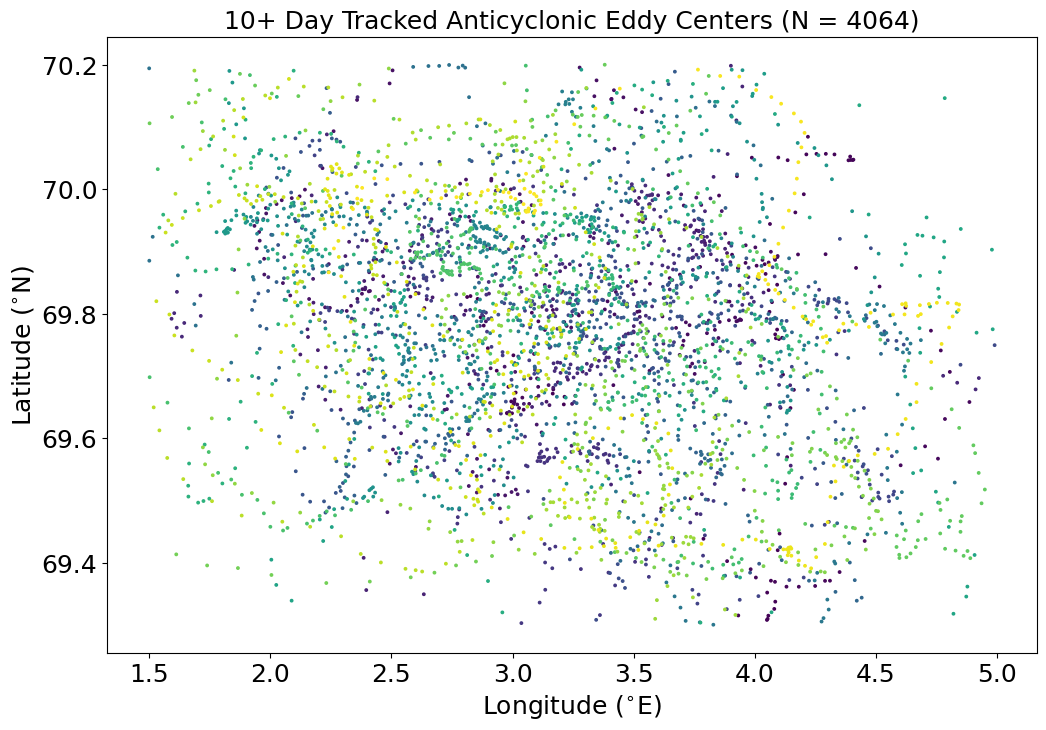

In [10]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.scatter(lon,lat,s=3,c=time)
scat = ax.set_title('10+ Day Tracked Anticyclonic Eddy Centers (N = %s)'%(len(track)))
ax.set_xlabel('Longitude ($^{\circ}$E)');
ax.set_ylabel('Latitude ($^{\circ}$N)');

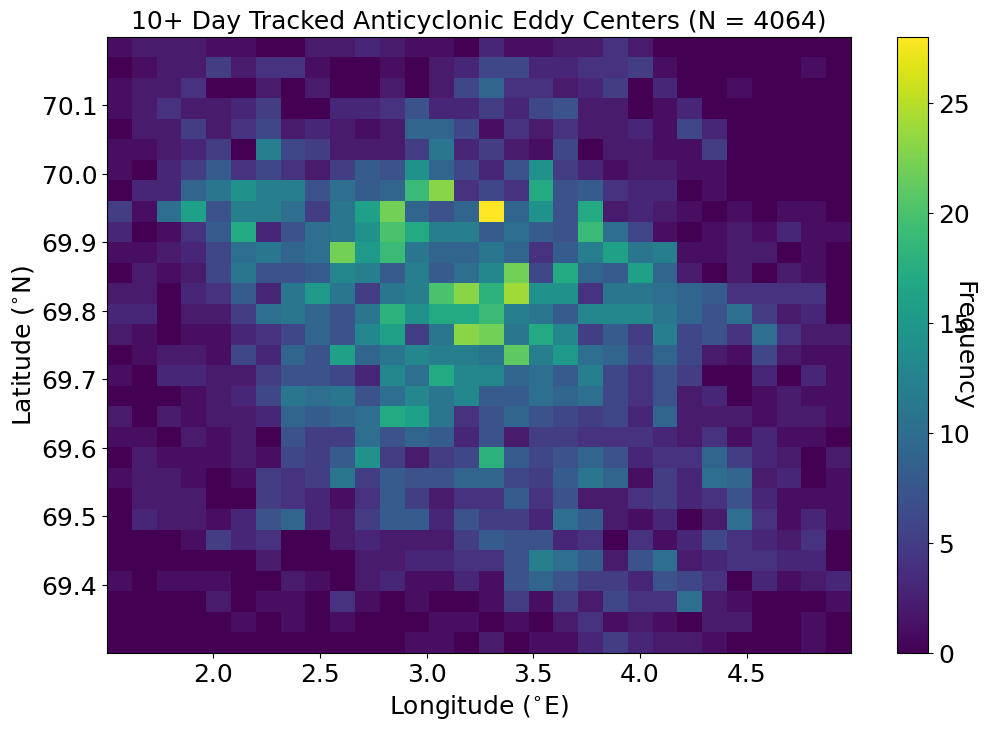

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

h = ax.hist2d(lon,lat,bins=30,vmin=0)
ax.set_title('10+ Day Tracked Anticyclonic Eddy Centers (N = %s)'%(len(track)))

cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label('Frequency', rotation=270)

ax.set_xlabel('Longitude ($^{\circ}$E)');
ax.set_ylabel('Latitude ($^{\circ}$N)');

Check location of max frequency of passes

In [93]:
max_inds = np.unravel_index(h[0].argmax(), h[0].shape)
print(lat[max_inds[0]])
print(lon[max_inds[1]])

69.63960266113281
3.1156005859375


### Check number of months of data w/ a track

In [170]:
obs_months = [(d.astype('datetime64[M]').astype(int) % 12 + 1) for d in time]
real_months = [(d.astype('datetime64[M]').astype(int) % 12 + 1) for d in np.arange('2010', '2022-02-09', dtype='datetime64[D]')]

In [171]:
print(len(obs_months))
print(len(real_months))

4077
4422


In [172]:
obs = []
xvals = np.arange(1,13)
for x in xvals:
    obs.append(obs_months.count(x))

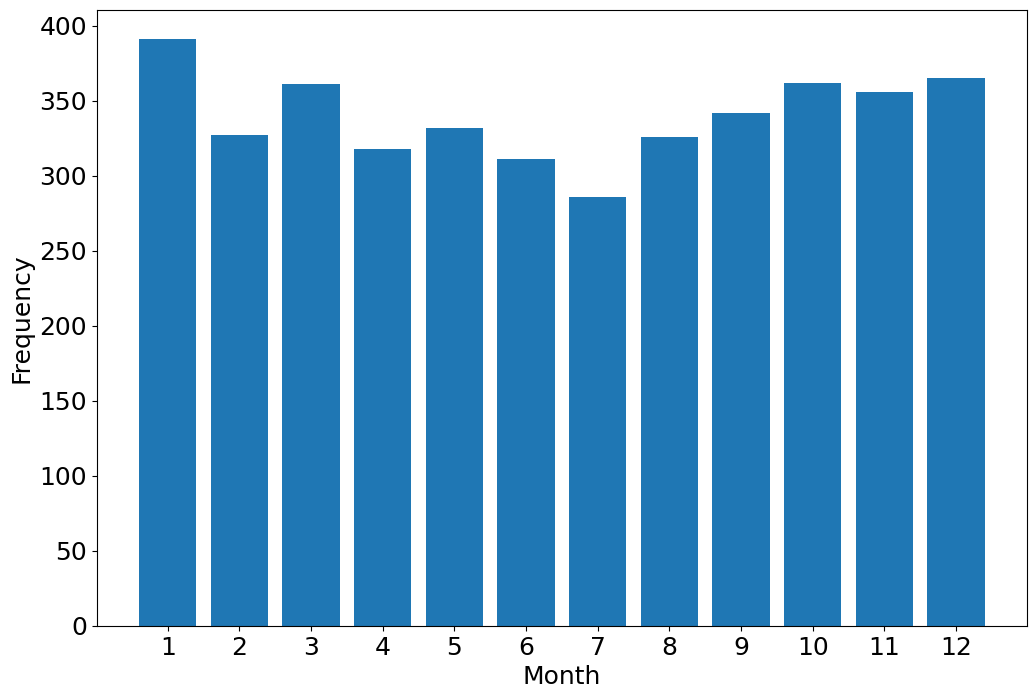

In [173]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.bar(np.arange(1,13),obs)
ax.set_xticks(xvals)

ax.set_ylabel('Frequency')
ax.set_xlabel('Month')

plt.show()

## Find dates with multiple tracks on the same day

In [12]:
np.unique(track)

array([417635, 504597, 542646, 548225, 586453, 598992, 667049, 756724])

In [13]:
cnt = Counter(time)
date_overlap = [k for k, v in cnt.items() if v > 1]

In [14]:
print(len(date_overlap)) # only 17 days of overlaps, but still weird
print(len(time))

17
4064


In [15]:
overlap_track_pairs = []
for d in date_overlap:
    inds = np.where(np.array(time) == d)[0]
    tracks = [track[i] for i in inds]
    if tracks not in overlap_track_pairs:
        overlap_track_pairs.append(tracks)

print(overlap_track_pairs)

[[417635, 504597], [542646, 548225], [586453, 598992], [667049, 756724]]


In [16]:
for pair in overlap_track_pairs:
    for i in pair:
        print(str(i) + ': ')
        times = np.array(time)[np.where(np.array(track)==i)[0]]
        print(min(times))
        print(max(times))

417635: 
2010-01-01T00:00:00.000000000
2011-05-28T00:00:00.000000000
504597: 
2011-05-22T00:00:00.000000000
2012-07-29T00:00:00.000000000
542646: 
2012-08-17T00:00:00.000000000
2012-10-26T00:00:00.000000000
548225: 
2012-10-26T00:00:00.000000000
2014-03-09T00:00:00.000000000
586453: 
2014-03-16T00:00:00.000000000
2014-09-18T00:00:00.000000000
598992: 
2014-09-14T00:00:00.000000000
2017-01-18T00:00:00.000000000
667049: 
2017-02-16T00:00:00.000000000
2020-05-21T00:00:00.000000000
756724: 
2020-04-29T00:00:00.000000000
2022-02-09T00:00:00.000000000


In [17]:
def compare_eddy_tracks(id1,id2):
    eddy1_inds = np.where(np.array(track)==id1)[0]
    eddy2_inds = np.where(np.array(track)==id2)[0] 
    
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    
    ax.scatter(np.array(lon)[eddy1_inds],np.array(lat)[eddy1_inds],s=10,c='k',label=id1)
    ax.scatter(np.array(lon)[eddy2_inds],np.array(lat)[eddy2_inds],s=10,c='r',label=id2)
    
    ax.set_xlabel('Longitude ($^{\circ}$E)');
    ax.set_ylabel('Latitude ($^{\circ}$N)');

    plt.legend(title='Eddy IDs')
    plt.show()

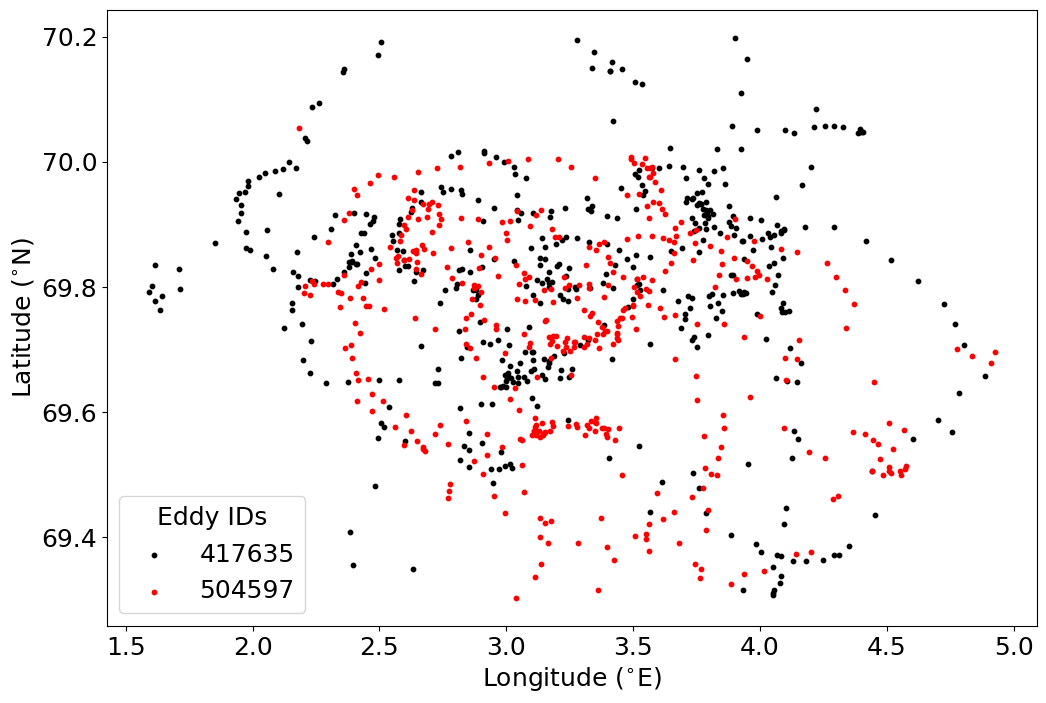

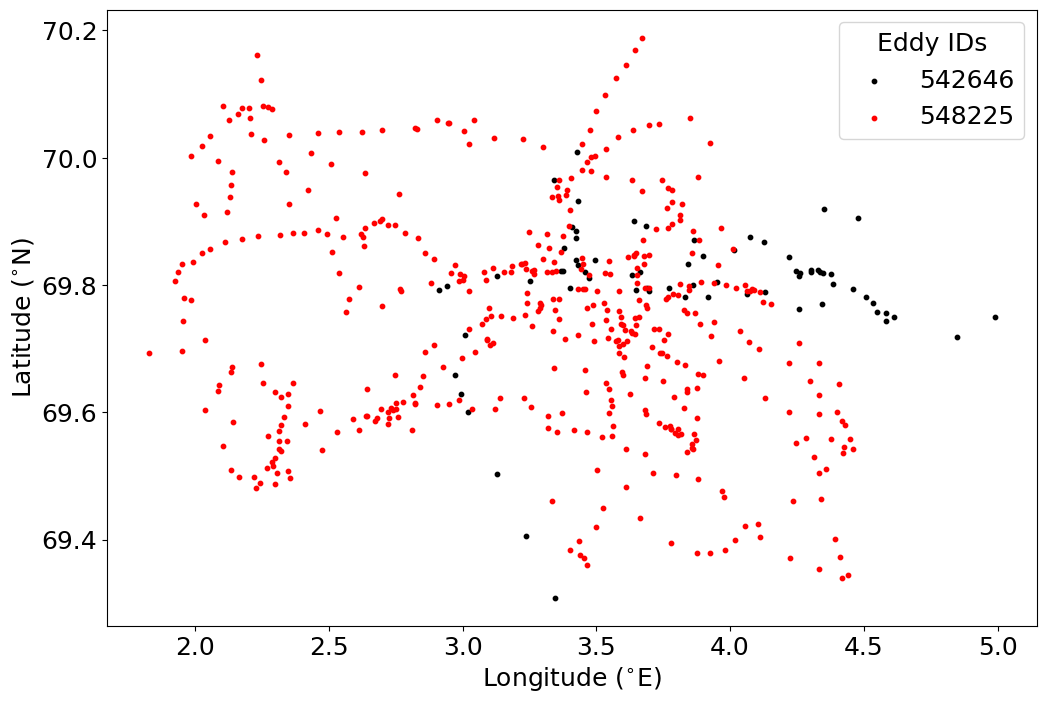

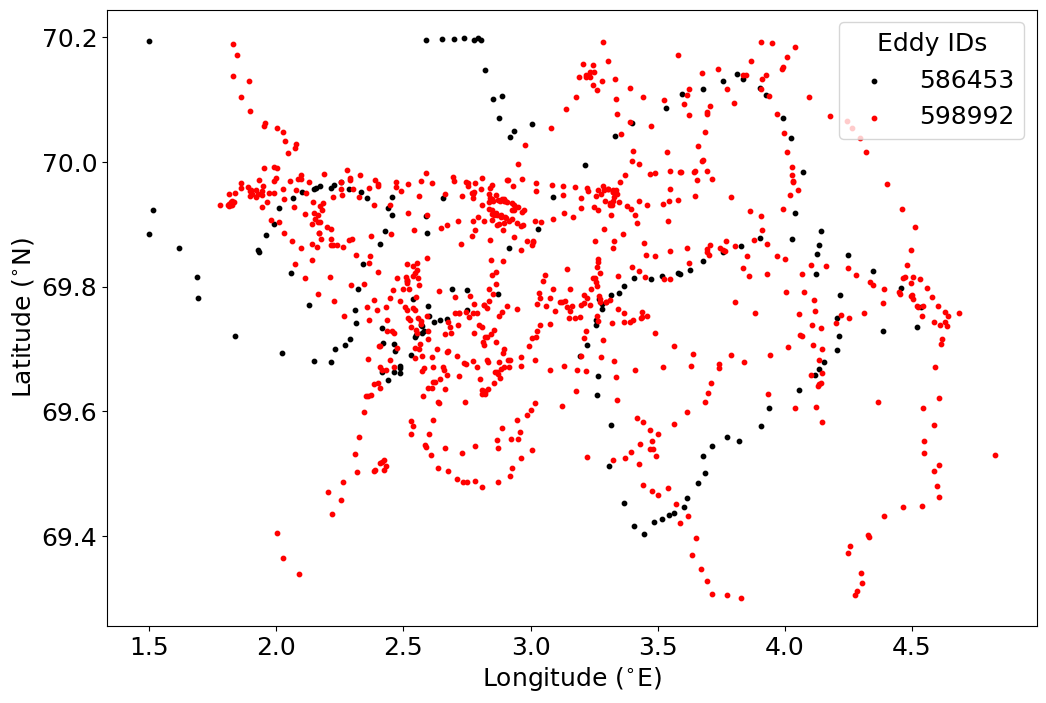

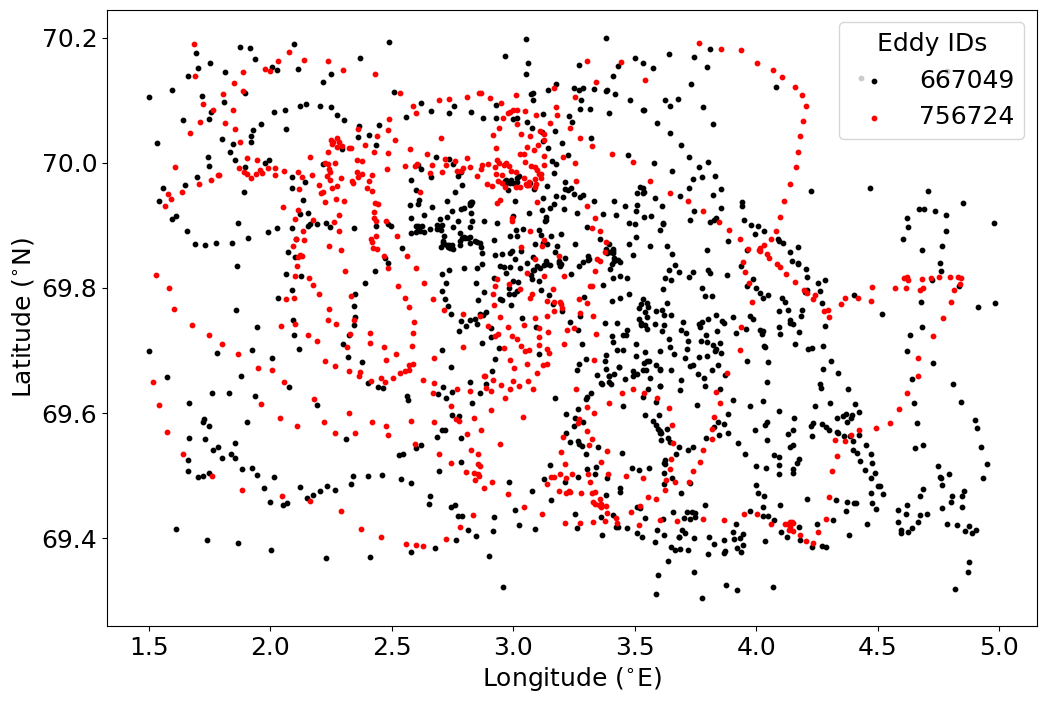

In [18]:
for i in overlap_track_pairs:
    compare_eddy_tracks(i[0], i[1])

## Plot eddy countours on days of overlap

In [19]:
def index_cmap(NUM_COLORS,cmap):
    cm = pylab.get_cmap(cmap)
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    return colors

In [20]:
id1, id2 = 667049, 756724 #586453, 598992# 542646, 548225 #417635, 504597
eddy1_inds = np.where(np.array(track)==id1)[0]
eddy2_inds = np.where(np.array(track)==id2)[0] 

In [24]:

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

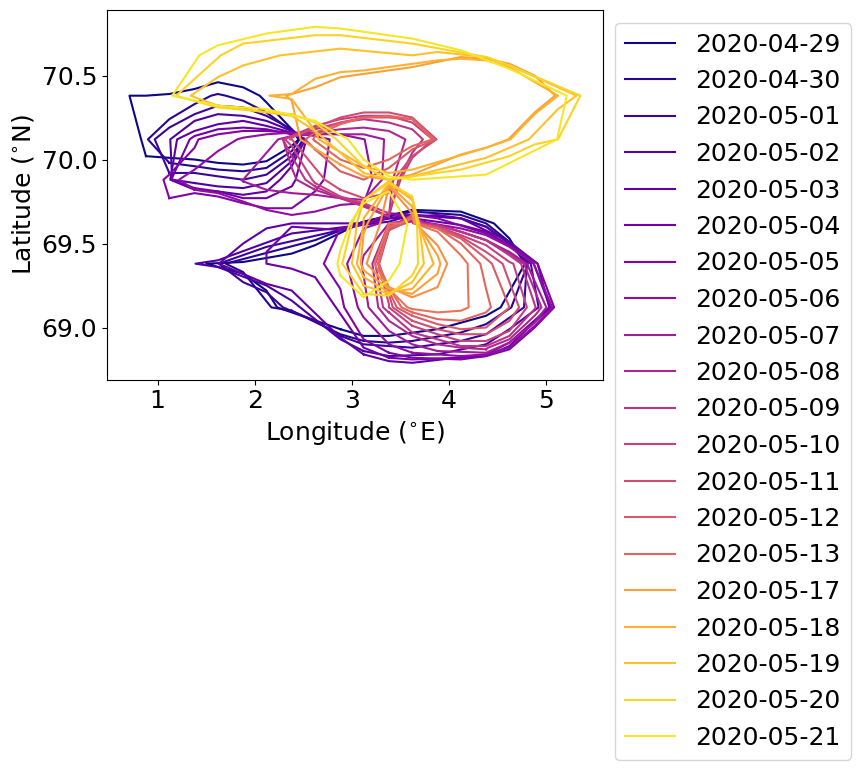

In [149]:
overlap_dates = ['2020-04-29','2020-04-30','2020-05-01','2020-05-02','2020-05-03','2020-05-04','2020-05-05','2020-05-06','2020-05-07',
                '2020-05-08','2020-05-09','2020-05-10','2020-05-11','2020-05-12','2020-05-13','2020-05-14','2020-05-15','2020-05-16',
                '2020-05-17','2020-05-18','2020-05-19','2020-05-20','2020-05-21']

#['2014-09-14','2014-09-15','2014-09-16','2014-09-17','2014-09-18']
#['2012-10-26'] 
#['2011-05-23','2011-05-24','2011-05-25','2011-05-26','2011-05-27','2011-05-28'] #There's weird cases where the eddy collapses: '2011-05-22'

colors = index_cmap(len(overlap_dates),'plasma')

for d in np.arange(0,len(overlap_dates)):
    ind1 = np.where((ds_anti.track == id1) & (ds_anti.time == np.datetime64(overlap_dates[d])))[0][0]
    contour_lons1 = np.array(ds_anti.effective_contour_longitude[ind1])
    contour_lats1 = np.array(ds_anti.effective_contour_latitude[ind1])
    if not(all_equal(contour_lons1)):
        plt.plot(contour_lons1,contour_lats1,c=colors[d])

    ind2 = np.where((ds_anti.track == id2) & (ds_anti.time == np.datetime64(overlap_dates[d])))[0][0]
    contour_lons2 = np.array(ds_anti.effective_contour_longitude[ind2])
    contour_lats2 = np.array(ds_anti.effective_contour_latitude[ind2])
    if not(all_equal(contour_lons2)):
        plt.plot(contour_lons2,contour_lats2,c=colors[d],label=overlap_dates[d])

plt.xlabel('Longitude ($^{\circ}$E)');
plt.ylabel('Latitude ($^{\circ}$N)');
plt.legend(bbox_to_anchor=(1,1));

In [141]:
len(np.where((ds_anti.track == id1))[0])

83

23370058
23370062
23370088
23370118
23370120
23370121


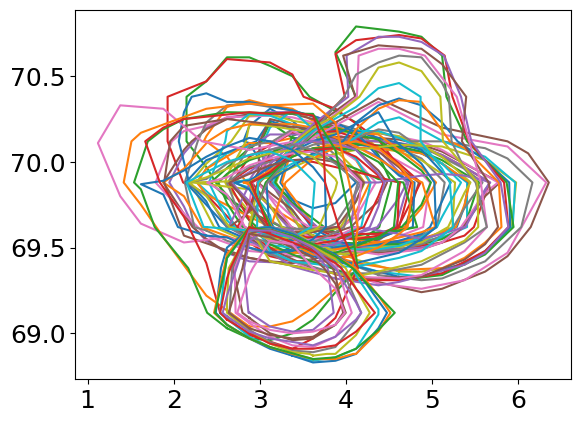

In [139]:
for i in np.where((ds_anti.track == id1))[0]:
    contour_lons1 = np.array(ds_anti.effective_contour_longitude[i])
    contour_lats1 = np.array(ds_anti.effective_contour_latitude[i])

    if all_equal(contour_lons1):
        print(i)
    else:
        plt.plot(contour_lons1,contour_lats1)

## Plot timeline of data

In [168]:
from datetime import datetime

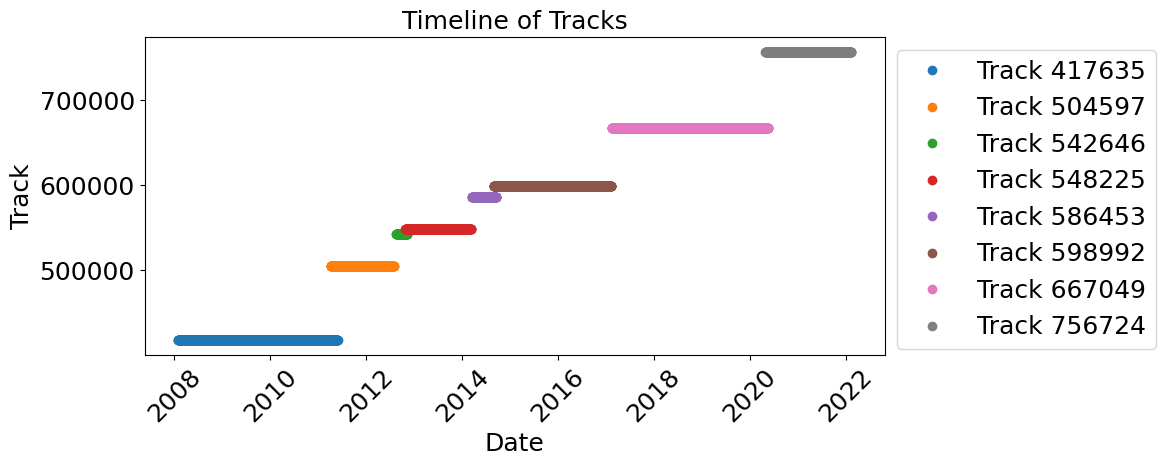

In [21]:
fig,ax = plt.subplots(1,1,figsize=(12,5))

for t in np.unique(track):
    times = np.array(ds_anti.time[np.where(ds_anti.track == t)[0]])
    ax.plot(times, np.ones_like(times,dtype=int) * t, 'o', label=f'Track {t}')

ax.set_xlabel('Date')
ax.set_ylabel('Track')
ax.set_title('Timeline of Tracks')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Subset AVISO to LBE IDs

In [52]:
np.unique(track)

array([417635, 504597, 542646, 548225, 586453, 598992, 667049, 756724])

In [55]:
ds_anti.track

<xarray.DataArray 'track' (obs: 34521490)>
array([     0,      0,      0, ..., 805894, 805894, 805894], dtype=uint32)
Dimensions without coordinates: obs
Attributes:
    comment:    Trajectory identification number
    long_name:  Trajectory number
    min:        0
    max:        805894

In [77]:
subset_ds = ds_anti.sel({track: [417635, 504597, 542646, 548225, 586453, 598992, 667049, 756724]})

TypeError: unhashable type: 'list'

In [60]:
ds_anti

<xarray.Dataset>
Dimensions:                        (obs: 34521490, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/28)
    amplitude                      (obs) float64 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float64 ...
    effective_contour_longitude    (obs, NbSample) float64 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 ...
    speed_contour_shape_error      (obs) float64 ...
    speed_radius                   (obs) float64 ...
    time                           (obs) datetime64[ns] 1993-01-01 ... 2022-0...
    track                          (obs) uint32 0 0 0 0 ... 805894 805894 805894
    uavg_profile                   (obs, NbSample) float64 ...
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [67]:
inds = list(np.where((ds_anti.track == 417635)|(ds_anti.track == 504597)|
                          (ds_anti.track == 542646)|(ds_anti.track == 548225)|
                          (ds_anti.track == 586453)|(ds_anti.track == 598992)|
                          (ds_anti.track == 667049)|(ds_anti.track == 756724))[0])
inds

array([17973901, 17973902, 17973903, ..., 32565460, 32565461, 32565462])

In [88]:
ds_LBE = ds_anti.isel(obs=inds)
ds_LBE

<xarray.Dataset>
Dimensions:                        (obs: 5213, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/28)
    amplitude                      (obs) float64 ...
    cost_association               (obs) float32 ...
    effective_area                 (obs) float32 ...
    effective_contour_height       (obs) float32 ...
    effective_contour_latitude     (obs, NbSample) float64 ...
    effective_contour_longitude    (obs, NbSample) float64 ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 ...
    speed_contour_shape_error      (obs) float64 ...
    speed_radius                   (obs) float64 ...
    time                           (obs) datetime64[ns] 2008-01-30 ... 2022-0...
    track                          (obs) uint32 417635 417635 ... 756724 756724
    uavg_profile                   (obs, NbSample) float64 ...
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [89]:
for t in np.unique(ds_LBE.track):
    print(t)
    inds = np.where(ds_LBE.track == t)[0]
    print('Start: %s'%(np.array(ds_LBE.time[inds[0]])))
    print('End: %s'%(np.array(ds_LBE.time[inds[-1]])))
    print('Length: %s days'%((np.array(ds_LBE.time[inds[-1]])-np.array(ds_LBE.time[inds[0]])).astype('timedelta64[D]').astype('int')))
    breaks = []
    for i in inds:
        contour_lons = np.array(ds_LBE.effective_contour_longitude[i])
        if all_equal(contour_lons):
            breaks.append(ds_LBE.time[i].values.astype('str')[0:10])
    print('Break: %s'%(breaks))

417635
Start: 2008-01-30T00:00:00.000000000
End: 2011-05-28T00:00:00.000000000
Length: 1214 days
Break: ['2008-02-09', '2008-02-10', '2008-09-20', '2008-11-13', '2009-02-24', '2009-05-26', '2009-09-07', '2009-09-21', '2010-04-22', '2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11', '2011-02-28', '2011-03-03', '2011-03-06', '2011-03-07', '2011-05-22']
504597
Start: 2011-04-05T00:00:00.000000000
End: 2012-07-29T00:00:00.000000000
Length: 481 days


KeyboardInterrupt: 

In [91]:
track_info = [['ID','Start_date','End_date','Length_days','Num_breaks','Break_dates']]

for t in np.unique(ds_LBE.track):
    
    inds = np.where(ds_LBE.track == t)[0]
    
    breaks = []
    for i in inds:
        contour_lons = np.array(ds_LBE.effective_contour_longitude[i])
        if all_equal(contour_lons):
            breaks.append(ds_LBE.time[i].values.astype('str')[0:10])

    track_info.append([t,ds_LBE.time[inds[0]].values.astype('str')[0:10],ds_LBE.time[inds[-1]].values.astype('str')[0:10],
                 (np.array(ds_LBE.time[inds[-1]])-np.array(ds_LBE.time[inds[0]])).astype('timedelta64[D]').astype('int'),
                 len(breaks),breaks])

KeyboardInterrupt: 

In [99]:
from matplotlib.path import Path

In [98]:
for i in np.where(ds_LBE.time == np.datetime64('2013-10-30'))[0]:
    print(i)
    print(np.array(ds_LBE.effective_contour_longitude[i]))
    print(np.array(ds_LBE.effective_contour_latitude[i]))

2149
[2.12 2.38 3.38 3.88 4.38 4.62 4.79 4.89 4.62 4.38 3.38 2.88 2.64 2.5
 2.38 2.18 2.12 1.88 1.73 2.12]
[69.53 69.52 69.53 69.56 69.63 69.72 69.88 70.12 70.4  70.51 70.53 70.47
 70.38 70.12 69.98 69.88 69.79 69.65 69.62 69.53]


In [124]:
def in_eddy(float_lat,float_lon,float_time):
    """
    float_lat: degrees north
    float_lon:
    float_time: should be in format np.datetime64('YYYY-MM-DD')
    """

    in_eddy_flag = False 

    if float_time in ds_LBE.time: # some dates not in dateset
        for i in np.where(ds_LBE.time == float_time)[0]: # usually will only be 1 eddy, but sometimes there are 2 after a split
            contour_lons = np.array(ds_LBE.effective_contour_longitude[i]) # eddy lons
            contour_lats = np.array(ds_LBE.effective_contour_latitude[i]) # eddy lats
            
            if all_equal(contour_lons): # eddy break
                pass
            else:
                plt.plot(contour_lons,contour_lats)
                plt.scatter(float_lon,float_lat)
                
                poly = Path([(contour_lats[j],contour_lons[j]) for j in np.arange(0,len(contour_lats))]) # set up the polygon
        
                if poly.contains_points([(float_lat,float_lon)]): #find if point is inside the polygon
                    in_eddy_flag = True 

    return in_eddy_flag

True

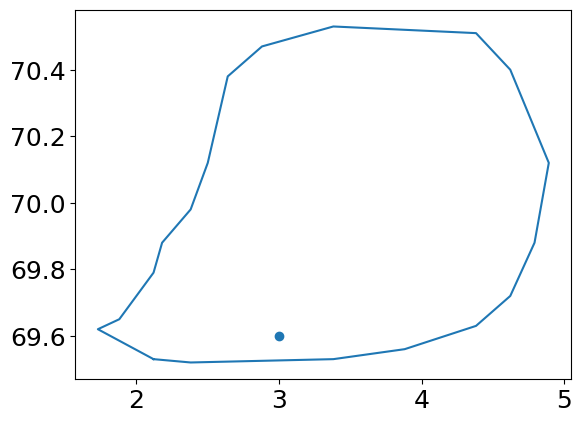

In [125]:
in_eddy(69.6,3,np.datetime64('2013-10-30'))